In [1]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import jax
import optax
import flax
from flax.training.train_state import TrainState
from functools import partial

from dataset.chirping_binary import ChirpingBinary
from models.signalprocessing import MambaSP
import training


print(f"JAX devices:{jax.devices()}")

JAX devices:[CpuDevice(id=0)]


In [2]:
rng_key = jax.random.key(0)
batch_size = 128

dataset = ChirpingBinary(episode_duration_s=10, sample_rate_Hz=100)
model = MambaSP(state_dim=32, n_layers=2)

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.24053402245044708


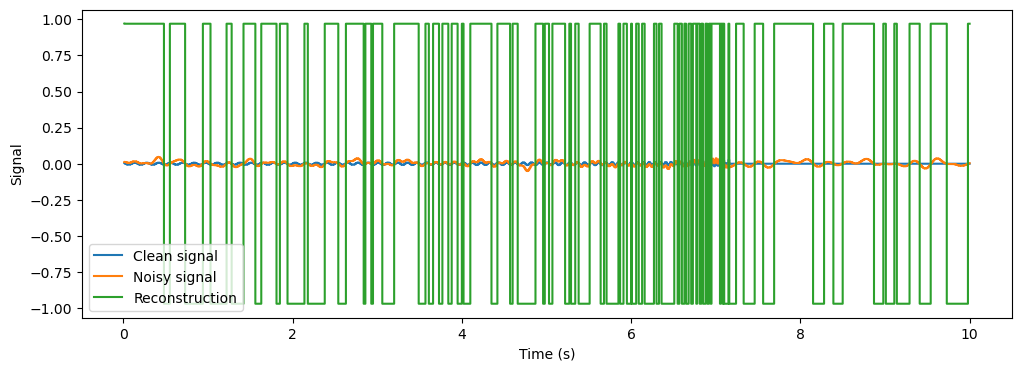

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.22348852455615997


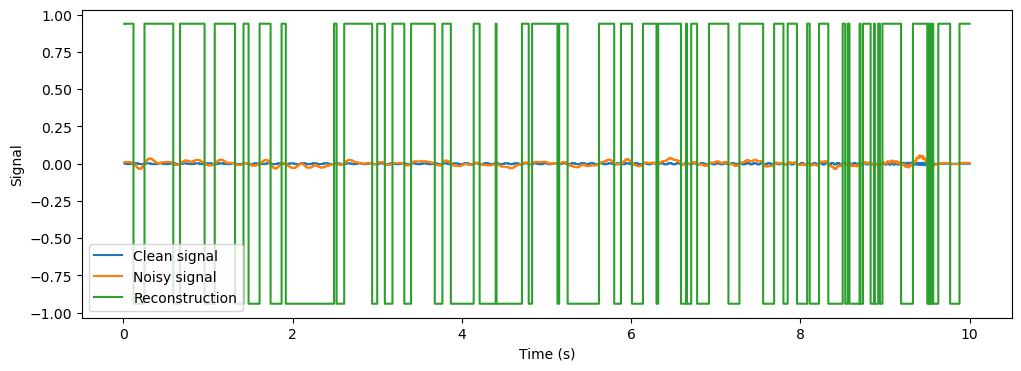

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.20808878540992737


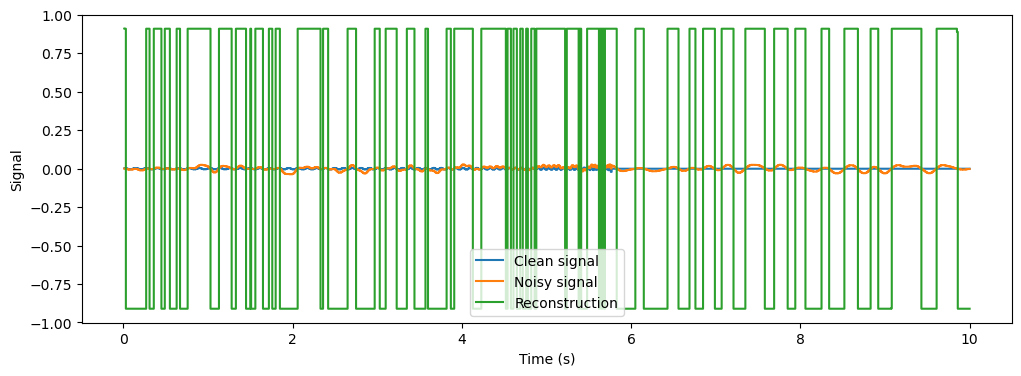

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.19672687351703644


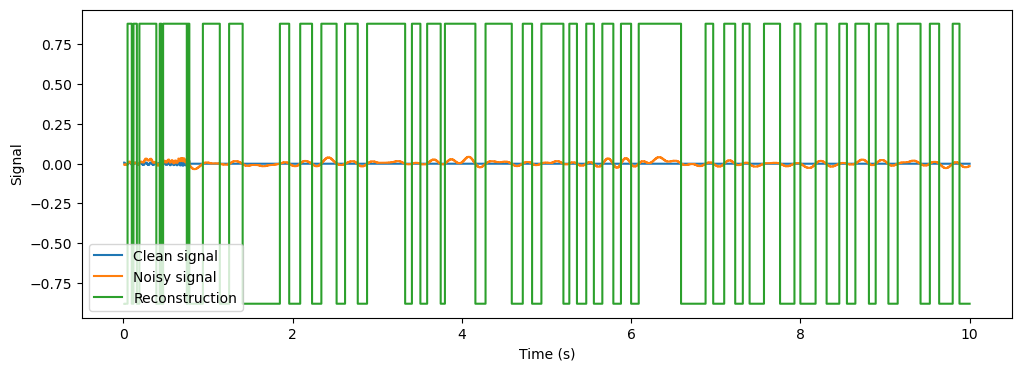

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1834239512681961


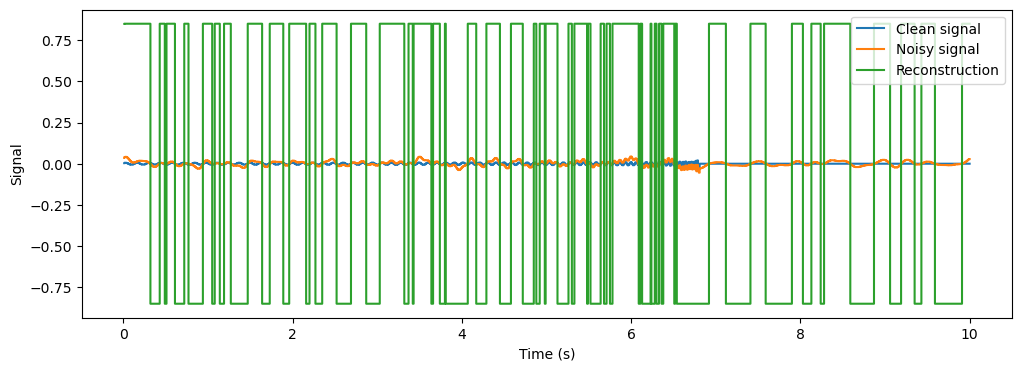

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.17151030898094177


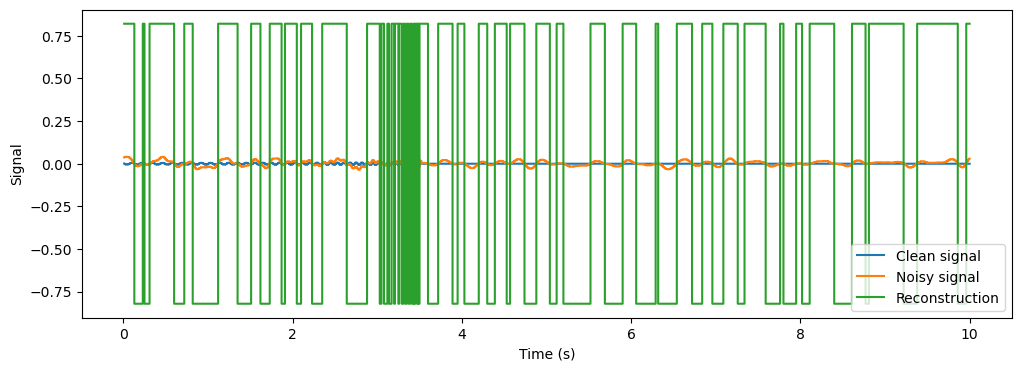

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1591435819864273


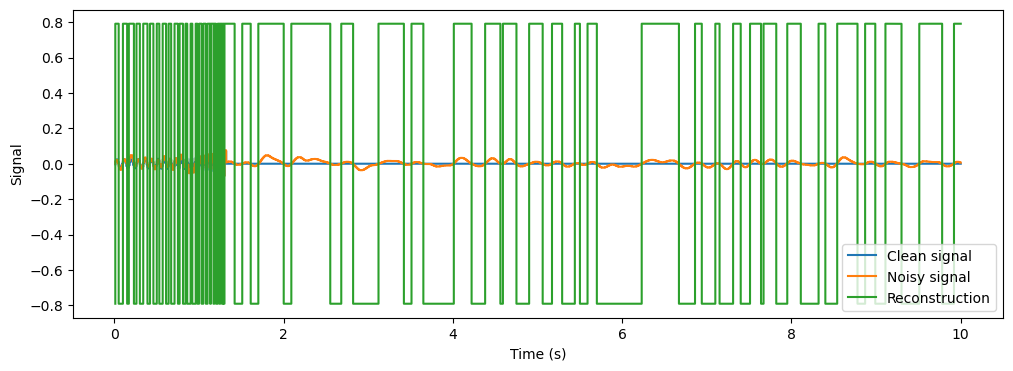

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.14783638715744019


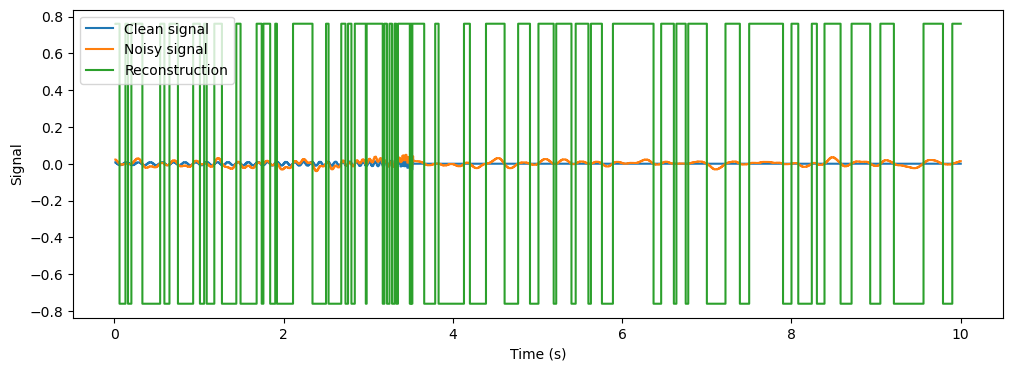

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.13665881752967834


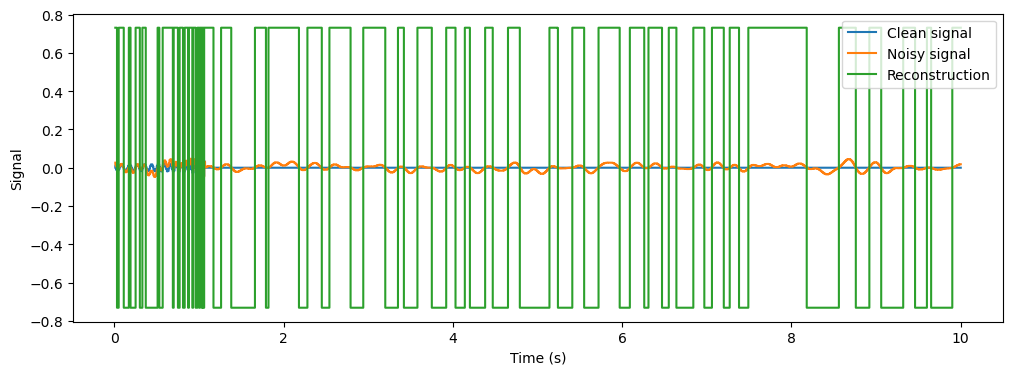

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.12554803490638733


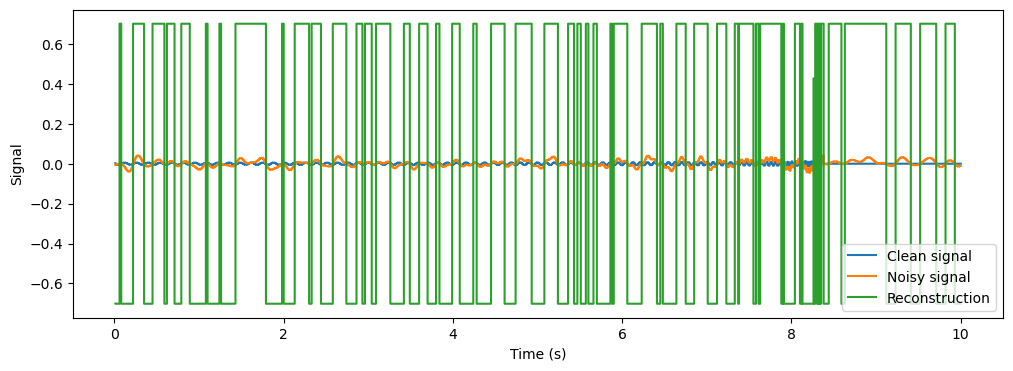

In [3]:
optimization_step = jax.jit(
    partial(training.optimization_step, loss_fn=training.signal_mse_loss)
)
get_batch = jax.jit(dataset.get_batch, static_argnames=["batch_size"])


train_state = TrainState.create(
    apply_fn=model.apply,
    params=model.init(rng_key, dataset.sample(rng_key)[0]),
    tx=optax.chain(optax.clip(1.0), optax.adam(3e-4, b2=0.95)),
)

N_epochs = 10
batches_per_epoch = 100
for epoch_idx, epoch_rng_key in tqdm(enumerate(jax.random.split(rng_key, N_epochs))):
    losses = []
    for batch_rng_key in tqdm(jax.random.split(epoch_rng_key, batches_per_epoch), leave=False):
        x, y = get_batch(batch_rng_key, batch_size)
        train_state, loss_value = optimization_step(train_state, x, y)
        losses.append(loss_value)

    print(f"Loss: {sum(losses) / len(losses)}")
    noisy_signal, clean_signal = dataset.sample(epoch_rng_key)
    reconstruction = train_state.apply_fn(train_state.params, noisy_signal)
    plt.figure(figsize=(12, 4))
    plt.step(dataset.times, clean_signal, label="Clean signal")
    plt.step(dataset.times, noisy_signal, label="Noisy signal")
    plt.step(dataset.times, reconstruction, label="Reconstruction")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal")
    plt.legend()
    plt.show()